# _I - Setting up_

### _Imports_

In [287]:
import numpy as np
import pandas as pd
import keras
import itertools
import shutil
import os
import csv
from ast import literal_eval
from keras import backend as K
from keras.layers import Activation, Dropout
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.regularizers import l2
from keras.models import Model
from keras.models import clone_model
from keras.applications import imagenet_utils
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

### _Global variables_

In [526]:
train_path = "Data/Train"
valid_path = "Data/Validation"
test_path = "Data/Test"
pred_path = "Data/Prediction"
classes = ['buildings','forest','glacier','mountain','sea','street']

### _Reorganize the *Intel Image Classification* dataset downloaded from Kaggle_
(Assuming that the dataset is extracted in the same folder as this notebook)

In [98]:
# Renaming
os.rename('intel-image-classification', 'Data')

# Reorganize the dataset
shutil.move('Data/seg_pred/seg_pred', 'Data/Prediction')
shutil.move('Data/seg_test/seg_test', 'Data/Test')
shutil.move('Data/seg_train/seg_train', 'Data/Train')
os.rmdir('Data/seg_pred')
os.rmdir('Data/seg_test')
os.rmdir('Data/seg_train')

print("Finished reorganizing")

Finished reorganizing


In [99]:
def shrink(s_factor = 4):
    """
    Shrinks the train and test dataset by a factor of n
    
    Parameters:
    -n (int) : the factor by which the dataset gets shrinked
    
    """
    for path in [train_path,test_path]:
        image_idx = 0
        # Shrinking the dataset
        for c in classes:
            images = os.listdir(path + '/' + c)
            for i in images:
                if (((image_idx) % s_factor ) != 0):
                    os.remove(path + '/' + c + '/' + i)
                image_idx += 1

In [100]:
def create_validation(ratio = 0.2):
    """ 
    Splits the training data into train and validation (to use Keras's flow_from_directory)
  
    Parameters: 
    -ratio (float): ratio of the train data to use as validation
      
    """
    # Creating a directory for the validation folder
    os.mkdir(valid_path)
        
    # Splitting
    image_idx = 1
    for c in classes:
        os.mkdir(valid_path + '/' + c)
        images = os.listdir(train_path + '/' + c)
        for i in images:
            if ((image_idx) % int(1/ratio) == 0):
                shutil.move(train_path + '/' + c + '/' + i, valid_path + '/' + c + '/' + i)
            image_idx += 1

### _Shrinking the dataset (run this cell only if your pc cannot handle the dataset !)_

In [101]:
# Shrink the dataset by a factor of 4
shrink()

print("Finished shrinking")

Finished shrinking


In [102]:
# Create a validation set with a ratio of 0.2
create_validation()

print("Finished creating validation set")

Finished creating validation set


### _Visualize the dataset_

In [103]:
def plots(imgs, figsize = (25,6), rows = 1, interp = False, titles = None):
    """ 
    Plots images with labels within jupyter notebook
    
    """
    if type(imgs[0]) is np.ndarray:
        imgs = np.array(imgs).astype(np.uint8)
        if (imgs.shape[-1] != 3):
            imgs = imgs.transpose((0,2,3,1))
    f = plt.figure(figsize = figsize)
    cols = len(imgs)//rows if len(imgs) % 2 == 0 else len(imgs)//rows + 1
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(imgs[i], interpolation=None if interp else 'none')

In [104]:
def create_batch_generator(data_path, classes_, batch_size_, target_size_ = (150,150), preprocessing_function_ = None, shuffle_ = True):
    """ 
    Creates a batch generator of data from the given directory
    
    Parameters:
    -data_path (string): path to the directory
    -classes_ (List[string]): list of the classes
    -batch_size_ (int): batch size of the batches to generate
    -preprocessing_function: preprocessing for the MobileNetV2
    
    Returns:
    ImageDataGenerator: batch generator
    
    """
    if (preprocessing_function_) is None :
        return ImageDataGenerator().flow_from_directory(data_path, target_size = target_size_, classes = classes_, batch_size = batch_size_, shuffle = shuffle_)
    else :
        return ImageDataGenerator(preprocessing_function = preprocessing_function_).flow_from_directory(data_path, target_size = target_size_, classes = classes_, batch_size = batch_size_, shuffle = shuffle_)

In [105]:
# Generate a raw data batch generator to visualize the dataset
raw_batches = create_batch_generator(train_path, classes, 5)

# Print the class indices
raw_batches.class_indices

Found 2808 images belonging to 6 classes.


{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

/home/seijin/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



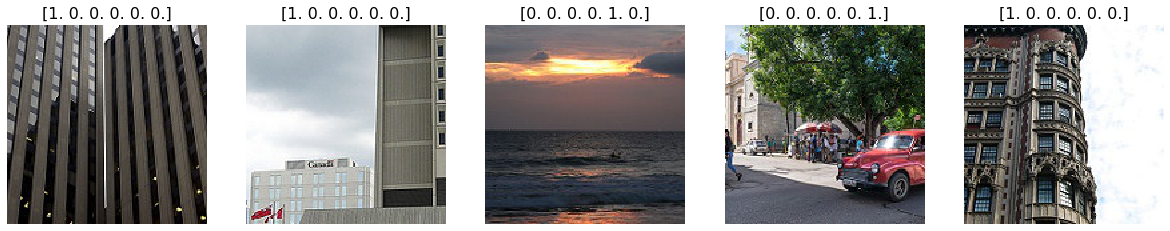

In [456]:
# Visualize some data samples
imgs, labels = next(raw_batches)
plots(imgs, titles = labels)

# _II - Fine-tuning MobileNetV2_

### _Variables_

In [534]:
batch_size = 64
target_size = (224,224) # Expected input image dimensions by the MobileNetV2
learning_rate = 0.0005
loss_f = 'categorical_crossentropy'
dropout = 0.5
weight_decay = 0.0001
n_epochs = 40

### _Batch generators_

In [535]:
train_batches = create_batch_generator(train_path, classes, batch_size, target_size, keras.applications.mobilenet_v2.preprocess_input)
valid_batches = create_batch_generator(valid_path, classes, batch_size, target_size, keras.applications.mobilenet_v2.preprocess_input)
test_batches = create_batch_generator(test_path, classes, batch_size, target_size, keras.applications.mobilenet_v2.preprocess_input, False)

Found 2808 images belonging to 6 classes.
Found 701 images belonging to 6 classes.
Found 750 images belonging to 6 classes.


### _Instanciate a MobileNetV2_

In [536]:
model = keras.applications.mobilenet_v2.MobileNetV2()

In [537]:
# Summary of the model
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_21[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

### _Change the prediction layer of the model_

In [538]:
# Add a dropout before the last layer to regularize
x = (Dropout(rate = dropout, input_shape = (1280,)))(model.layers[-2].output)

# Change the last layer to a 6 class classification layer with a softmax activation function combined with a weight decay
last_layer = Dense(6, kernel_regularizer = l2(weight_decay), activation = 'softmax')(x)

# Changed model
model = Model(inputs = model.input, outputs = last_layer)

In [539]:
# Summary of the model with modified prediction layer
model.summary()

Model: "model_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_21[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
___________________________________________________________________________________________

### _Gridsearch for hyper-parameter tuning_

In [540]:
# Takes as input the MobileNetV2 to decide for the hyper parameters for the last layers
def grid_search(model):
    """ 
    Runs a grid search algorithm for the modified MobileNetV2 model. 
    This function takes as input the unmodified MobileNetV2 model, modifies it, 
    and exports the training history into a .csv file, for each combination of hyper-parameters specified below.
    
    Parameters:
    -model : The unmodified MobileNetV2 model
    
    """
    
    # Searching parameters
    dropouts = [0.1, 0.3, 0.5]
    weight_decays = [0.00001, 0.0001, 0.001, 0.01]
    learning_rates = [0.0005, 0.001, 0.005]
    
    # Local variables
    histories = []
    step = 0
    
    # Prepare the csv file to export the histories
    csv_columns = ['val_loss','val_accuracy','loss','accuracy','dropout','weight_decay','learning_rate']
    csv_file = open("gridsearch.csv", "a")
    writer = csv.DictWriter(csv_file, fieldnames = csv_columns)    
    writer.writeheader()    

    for d in dropouts:
        for wd in weight_decays:
            for lrate in learning_rates:
                
                    # Clone the MobileNetV2
                    m = clone_model(model)
                    m.set_weights(model.get_weights())
                    
                    # Add a dropout before the last layer to regularize
                    x = (Dropout(rate = d, input_shape=(1280,)))(m.layers[-2].output)
                    
                    # Change the last layer to a 6 class classification layer with a softmax activation function combined with a weight decay
                    last_layer = Dense(6, kernel_regularizer = l2(wd), activation = 'softmax')(x)
                    m = Model(inputs = m.input, outputs = last_layer)
                    
                    # Freezing the already trained layers so that their parameters don't get updated when training the last layer
                    for layer in m.layers[:-1]:
                        layer.trainable = False
                        
                    # Compile the model, use an Adam optimizer
                    m.compile(Adam(lr = lrate), loss = loss_f, metrics = ['accuracy'])
                    history = m.fit_generator(train_batches, validation_data = valid_batches, epochs = n_epochs, verbose = 0)
                    
                    # Save the history
                    history.history['dropout'] = d
                    history.history['weight_decay'] = wd
                    history.history['learning_rate'] = lrate
                    writer.writerow(history.history)
                    
                    # Increment the step
                    print("\nStep : ", step)
                    step += 1
    
    # Return the histories
    csv_file.close()
    return histories

In [542]:
# Grid search to tune the learning rate, dropout rate and weight decay, over 25 epochs

# grid_search(keras.applications.mobilenet_v2.MobileNetV2())

### _Find the best hyper-parameters_

In [543]:
# Load the saved training histories of the grid search algorithm
df = pd.read_csv('gridsearch.csv')
df.head()

,val_loss,val_accuracy,loss,accuracy,dropout,weight_decay,learning_rate
0,"[1.0036860704421997, 0.6715518236160278, 0.508...","[0.6348074078559875, 0.7631954550743103, 0.787...","[1.6311353370335027, 0.9574710799757912, 0.726...","[0.35363248, 0.6442308, 0.73183763, 0.7934473,...",0.1,0.00001,0.0005
1,"[0.784997820854187, 0.5298510193824768, 0.4312...","[0.7489300966262817, 0.7774607539176941, 0.807...","[1.374940718680705, 0.652715831400662, 0.51949...","[0.47792023, 0.7724359, 0.8158832, 0.84045583,...",0.1,0.00001,0.0010
2,"[0.29699084162712097, 0.2648340165615082, 0.31...","[0.855920135974884, 0.8502140045166016, 0.8516...","[0.8152461848367653, 0.43527393785976615, 0.37...","[0.70263535, 0.84508544, 0.8593305, 0.8742877,...",0.1,0.00001,0.0050
3,"[1.0670417547225952, 0.5748893022537231, 0.704...","[0.6262482404708862, 0.7774607539176941, 0.803...","[1.7043640552422938, 0.9793478352391821, 0.724...","[0.3340456, 0.63924503, 0.74572647, 0.77884614...",0.1,0.00010,0.0005
4,"[0.7067393660545349, 0.48477134108543396, 0.47...","[0.8059914112091064, 0.8330955505371094, 0.828...","[1.245724800984744, 0.6372891248461188, 0.5093...","[0.519943, 0.75498575, 0.82229346, 0.8326211, ...",0.1,0.00010,0.0010


In [544]:
# Parameters
dropouts = [0.1, 0.3, 0.5]
learning_rates = [0.0005, 0.001, 0.005]
weight_decays = [0.00001, 0.0001, 0.001, 0.01]

# Plot titles
plot_titles = []
for d in dropouts:
    for l in learning_rates:
        plot_titles.append("Dropout : " + str(d) + " & L.R. : " + str(l))

# Instanciate the figure
fig = make_subplots(rows = 3, cols = 3, subplot_titles = (plot_titles))    

# Change the font of the subplots title
for i in fig['layout']['annotations']:
    i['font'] = dict(size = 12,color = 'black')
    
# Plot all of the validation accuracies with respect to epochs
show_legend = True
colors = ['#5fa8d3','#1bc965','#5266cb','#be59e8']
for d in range(len(dropouts)):
    for l in range(len(learning_rates)):
        for w in range(len(weight_decays)):
            
            # Avoiding duplicate legends
            if ((d != 0)|(l != 0)):
                show_legend = False
            
            # Add trace
            fig.append_trace(go.Scatter(
                x = [e for e in range(25)],
                y = literal_eval(
                     df[(df['dropout'] == dropouts[d])&\
                    (df['weight_decay'] == weight_decays[w])&\
                    (df['learning_rate'] == learning_rates[l])]['val_accuracy'].tolist()[0]),
                legendgroup = str(w),
                name = 'W.D. : ' + str(weight_decays[w]),
                showlegend = show_legend,
                mode = 'lines+markers',
                marker = {'size':4},
                line = dict(
                    color = colors[w],
                    width = 1),
            ), row = d + 1, col = l + 1)

# Fill x and y axis for the first plot
fig.update_yaxes(title_text = "Validation accuracy (%)", row = 1, col = 1)
fig.update_xaxes(title_text = "Epoch", row = 1, col = 1)
fig.update_yaxes(range = [0.6, 0.9], autorange = False, tickfont = dict(size = 8), titlefont = dict(size = 10), showgrid = True, gridwidth = 1, gridcolor = 'LightGrey')
fig.update_xaxes(tickfont = dict(size = 8), titlefont = dict(size = 10), showgrid = True, gridwidth = 1, gridcolor = 'LightGrey')

# Add title and show the figure
fig.update_layout(height = 800, width = 950, title_text = "Validation accuracy with respect to epochs for different hyper parameters", title_x = 0.5)
fig.show()

__Observation__ : The best hyper-parameters seem to be the following :
- Learning rate = 0.0005
- Dropout = 0.5
- Weight decay = 0.0001

These parameters will be used for training that follows.

### _Train the model_

In [545]:
# Freezing the already trained layers so that their parameters don't get updated when training the last layer
for layer in model.layers[:-1]:
    layer.trainable = False

In [546]:
# Compile the model, use an Adam optimizer
model.compile(Adam(lr = learning_rate), loss = loss_f, metrics = ['accuracy'])

In [547]:
# Train the model with more epochs, with tuned hyper parameters
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = n_epochs, verbose = 0)

In [549]:
# Instanciate the figure
fig = make_subplots(rows = 2, cols = 1)    
fig.add_trace(go.Scatter(x = [e for e in range(40)], y = history.history['accuracy'],
                    mode ='lines+markers',
                    marker = {'size':5},
                    name ='Training Accuracy'), row = 1, col = 1)
fig.add_trace(go.Scatter(x = [e for e in range(40)], y = history.history['val_accuracy'],
                    mode ='lines+markers',
                    marker = {'size':5},
                    name ='Validation Accuracy'), row = 1, col = 1)
fig.add_trace(go.Scatter(x = [e for e in range(40)], y = history.history['loss'],
                    mode ='lines+markers',
                    marker = {'size':5},
                    name ='Training Loss'), row = 2, col = 1)
fig.add_trace(go.Scatter(x = [e for e in range(40)], y = history.history['val_loss'],
                    mode ='lines+markers',
                    marker = {'size':5},
                    name ='Validation Loss'), row = 2, col = 1)

# Fill x and y axis for the first plot
fig.update_xaxes(title_text = "Epoch", row = 2, col = 1)
fig.update_yaxes(tickfont = dict(size = 15), titlefont = dict(size = 15), showgrid = True, gridwidth = 1, gridcolor = 'LightGrey')
fig.update_xaxes(tickfont = dict(size = 15), titlefont = dict(size = 15), showgrid = True, gridwidth = 1, gridcolor = 'LightGrey')

# Add title and show the figure
fig.update_layout(height = 800, width = 950, title_text = "Histories of the fine-tuned MobileNetV2 over 40 epochs", title_x = 0.5)
fig.show()

__Observation__ : We should stop after 30 epochs.

### _Predictions of the model_

In [505]:
# Make predictions over all the loaded test data
test_labels = test_batches.classes
predictions = model.predict_generator(test_batches, verbose = 0)

In [523]:
def plot_confusion_matrix(cm, classes, title = 'Confusion matrix', cmap = plt.cm.Blues):
    """
    This function plots the confusion matrix.
    
    """
    plt.figure(figsize = (15,8))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

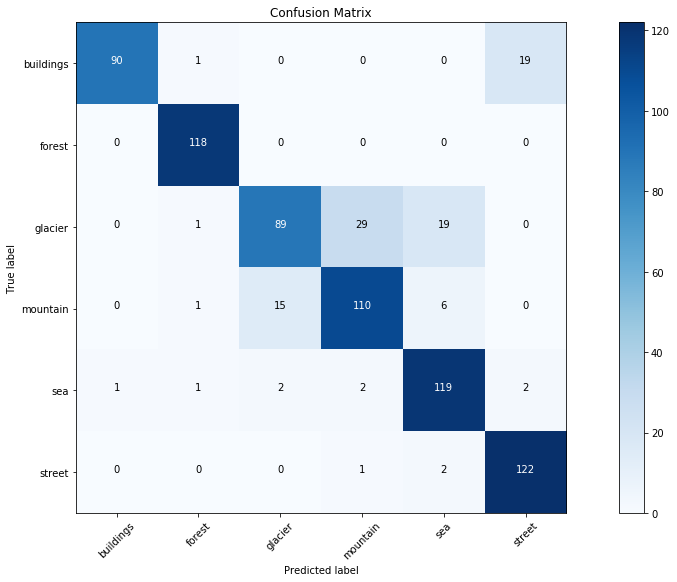

In [525]:
cm = confusion_matrix(test_labels, predictions.argmax(axis = 1))
cm_plot_labels = classes
plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

__Observation__ : Predictions are overall pretty accurate, but the model has a hard time distinguishing mountains and glaciers, or buildings and streets.

### _Overall performance of the model_

In [551]:
# Hyper parameters
learning_rate = 0.0005
weight_decay = 0.0001
dropout = 0.5

# Train the model 5 times over 40 epochs to get a more accurate measure of its performance
histories = []
for t in range(5):
    
    # Clone the MobileNetV2
    model = (keras.applications.mobilenet_v2.MobileNetV2())
    m = clone_model(model)
    m.set_weights(model.get_weights())

    # Add a dropout before the last layer to regularize
    x = (Dropout(dropout, input_shape = (1280,)))(m.layers[-2].output)

    # Change the last layer to a 6 class classification layer with a softmax activation function combined with a weight decay
    last_layer = Dense(6, kernel_regularizer = l2(weight_decay), activation = 'softmax')(x)
    m = Model(inputs = m.input, outputs = last_layer)

    # Freezing the already trained layers so that their parameters don't get updated when training the last layer
    for layer in m.layers[:-1]:
        layer.trainable = False

    # Compile the model, use an Adam optimizer
    m.compile(Adam(lr = learning_rate), loss = loss_f, metrics = ['accuracy'])
    history = m.fit_generator(train_batches, validation_data = valid_batches, epochs = 30, verbose = 0)
    
    # Save the history
    histories.append(history)

In [567]:
# Aggregate each metric of the histories
train_accs = []
valid_accs = []
train_losses = []
valid_losses= []
for history in histories:
    train_accs.append(history.history['accuracy'])
    valid_accs.append(history.history['val_accuracy'])
    train_losses.append(history.history['loss'])
    valid_losses.append(history.history['val_loss'])
    
# Compute the mean and the standard deviation
train_acc_mean = np.array(train_accs).mean(axis = 0)
train_acc_std = np.array(train_accs).std(axis = 0)
valid_acc_mean = np.array(valid_accs).mean(axis = 0)
valid_acc_std = np.array(valid_accs).std(axis = 0)
train_loss_mean = np.array(train_losses).mean(axis = 0)
train_loss_std = np.array(train_losses).std(axis = 0)
valid_loss_mean = np.array(valid_losses).mean(axis = 0)
valid_loss_std = np.array(valid_losses).std(axis = 0)

In [636]:
# Plot the performance of the model over 30 epochs

# Instanciate the figure
fig = make_subplots(rows = 1, cols = 2)    

# Parameters
epochs = np.array([e for e in range(30)])
epochs_rev = epochs[::-1]
train_acc_up = train_acc_mean + train_acc_std
train_acc_low = (train_acc_mean - train_acc_std)[::-1]
valid_acc_up = valid_acc_mean + valid_acc_std
valid_acc_low = (valid_acc_mean - valid_acc_std)[::-1]
train_loss_up = train_loss_mean + train_loss_std
train_loss_low = (train_loss_mean - train_loss_std)[::-1]
valid_loss_up = valid_loss_mean + valid_loss_std
valid_loss_low = (valid_loss_mean - valid_loss_std)[::-1]

# Plot the means of the training accuracy, validation accuracy, training loss, validation loss
fig.add_trace(go.Scatter(x = epochs, y = train_acc_mean,
                    mode ='lines+markers',
                    marker = {'size':5},
                    name ='Training Accuracy'), row = 1, col = 1)
fig.add_trace(go.Scatter(x = epochs, y = valid_acc_mean,
                    mode ='lines+markers',
                    marker = {'size':5},
                    name ='Validation Accuracy'), row = 1, col = 1)
fig.add_trace(go.Scatter(x = epochs, y = train_loss_mean,
                    mode ='lines+markers',
                    marker = {'size':5},
                    name ='Training Loss'), row = 1, col = 2)
fig.add_trace(go.Scatter(x = epochs, y = valid_loss_mean,
                    mode ='lines+markers',
                    marker = {'size':5},
                    name ='Validation Loss'), row = 1, col = 2)

# Plot the stds of the training accuracy, validation accuracy, training loss, validation loss
fig.add_trace(go.Scatter(
    x = np.concatenate((epochs, epochs_rev)),
    y = np.concatenate((train_acc_up, train_acc_low)),
    fill='toself',
    fillcolor='rgba(0,100,200,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Training Accuracy'), row = 1, col = 1)
fig.add_trace(go.Scatter(
    x = np.concatenate((epochs, epochs_rev)),
    y = np.concatenate((valid_acc_up, valid_acc_low)),
    fill='toself',
    fillcolor='rgba(200,100,00,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Validation Accuracy'), row = 1, col = 1)
fig.add_trace(go.Scatter(
    x = np.concatenate((epochs, epochs_rev)),
    y = np.concatenate((train_loss_up, train_loss_low)),
    fill='toself',
    fillcolor='rgba(0,200,100,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Training Loss'), row = 1, col = 2)
fig.add_trace(go.Scatter(
    x = np.concatenate((epochs, epochs_rev)),
    y = np.concatenate((valid_loss_up, valid_loss_low)),
    fill='toself',
    fillcolor='rgba(200,100,200,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Validation Loss'), row = 1, col = 2)

# Fill x and y axis for the first plot
fig.update_xaxes(title_text = "Epoch", row = 1, col = 1)
fig.update_xaxes(title_text = "Epoch", row = 1, col = 2)
fig.update_yaxes(title_text = "Accuracy (%)", row = 1, col = 1)
fig.update_yaxes(title_text = "Loss", row = 1, col = 2)
fig.update_yaxes(tickfont = dict(size = 15), titlefont = dict(size = 15), showgrid = True, gridwidth = 1, gridcolor = 'LightGrey')
fig.update_xaxes(tickfont = dict(size = 15), titlefont = dict(size = 15), showgrid = True, gridwidth = 1, gridcolor = 'LightGrey')

# Add title and show the figure
fig.update_layout(height = 800, width = 900, title_text = "Fine-tuned MobileNetV2 averaged over 5 runs ofb 30 epochs", title_x = 0.5)
fig.show()